# 의사결정나무(Decision Tree)

### 결정 트리
: 정답에 가장 빨리 도달하는 true/false 질문 목록을 학습하는 것<br>

  만약 tree를 만들때 모든 leaf node가 pure node가 될때 까지 진행하면<br>
  
  model의 복잡도가 매우 높아지고 오버피팅 됨

#### overfitting을 막는 전략 2가지
1. tree 생성을 사전에 중단하기(사전가지치기: pre-pruning)
2. 데이터 포인트가 적은 node를 삭제하거나 병합하기 : 사후 가지치기(post_pruning)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import graphviz
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

#### 의사 결정 나무 실습 - 와인데이터

In [30]:
from sklearn import datasets
raw_wine = datasets.load_wine()

X = raw_wine.data
y = raw_wine.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

#데이터 표준화
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
std_scale.fit(X_train)
X_tn_std = std_scale.transform(X_train)
X_te_std = std_scale.transform(X_test)

In [31]:
#데이터 학습
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier(random_state=0)
clf_tree.fit(X_tn_std, y_train)

#데이터 예측
pred_tree = clf_tree.predict(X_te_std)

#fl 스코어 평가
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred_tree, average='macro')
print('fl score: ',f1)

#분류리포트 사용
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred_tree)
print(class_report)

fl score:  0.9349141206870346
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.91      0.95      0.93        21
           2       0.89      1.00      0.94         8

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45



In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets

cancer = datasets.load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("훈련 세트 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(tree.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.937


모든리프노드가 순수노드이므로 훈련세트의 정확도는 100%<br>
즉 트리는 훈련 데이터의 모든 레이블을 완벽하게 기억.<br>
결정 트리의 깊이를 제한하지 않으면 트리는 무한정 깊어지고 복잡해짐<br>
가지치기 하지 않은 트리는 과대적합되기 쉽고 일반화과 어려움

### 사전 가지치기를 통한 학습 능력 판단하기

In [33]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(tree.score(X_test, y_test)))

훈련 세트 정확도: 0.988
테스트 세트 정확도: 0.951


가지치기는 훈련세트의 정확도를 떨어뜨리지만 테스트 세트의 성능은 개선됨
depth를 조절해 과대적합 방지 

#### 사전 가지치기 설정

*max_depth*: 트리의 최대 한도 깊이<br>
*max_leaf_nodes*: 리프노드의 최대개수 지정<br>
*random_state*: 여러번 실행해도 파라미터가 같을 경우 결과가 항상 같게 만들어줌

### 트리 그래프 그리기

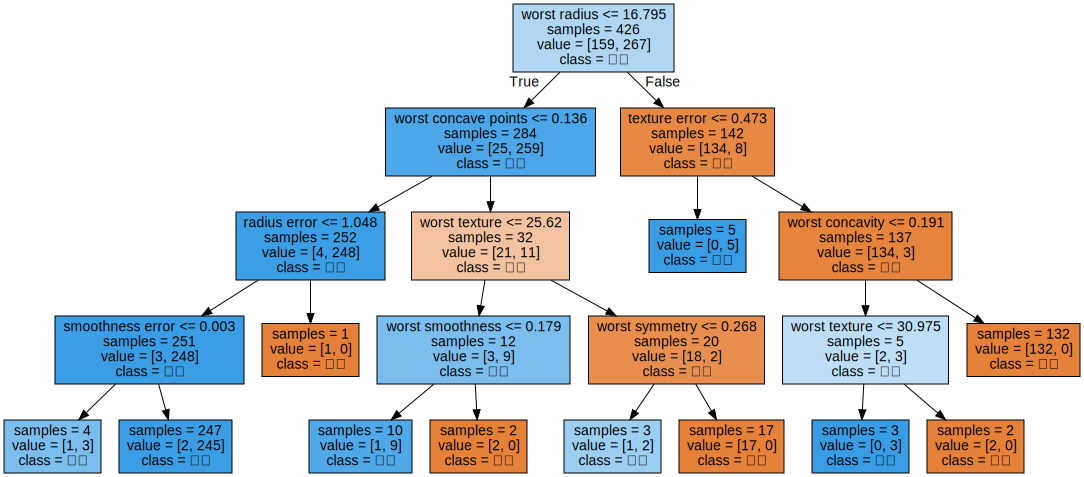

In [34]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree.dot',class_names=['악성','양성'],feature_names=cancer.feature_names, impurity=False, filled=True)

import graphviz

with open('tree.dot', encoding='utf-8') as f:
    dot_graph= f.read()

display(graphviz.Source(dot_graph))

**samples**: 노드 안에 들어 있는 데이터의 개수<br>
**value**: 분류값 별 데이터의 개수<br>
**class**: 분류값<br>
트리를 시각화하면 알고리즘의 예측이 어떻게 이뤄지는지 이해하기 좋다. 하지만 트리의 depth가 깊어지면 보기가 힘들어 진다.

### 트리의 특성 중요도(feature importance)

    :0과1 사이의 숫자로, 트리를 만드는 결정에 각 특성이 얼마나 중요한지 평가
     1에 가까울 수록 타깃 클래스 예측률 높음
 
 * 특성 중요도의 합은 1

In [35]:
print('특성 중요도: \n', tree.feature_importances_)

특성 중요도: 
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


#### 특성 중요도 시각화

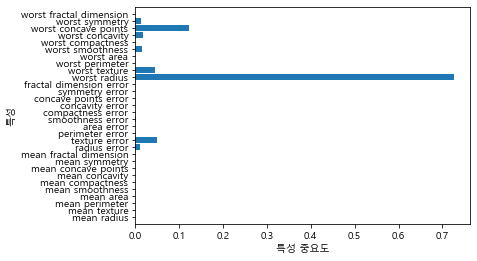

In [40]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features),model.feature_importances_,align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel('특성 중요도')
    plt.ylabel('특성')
    plt.ylim(-1, n_features)
    
plot_feature_importances_cancer(tree)

mean radius:0.000
mean texture:0.000
mean perimeter:0.000
mean area:0.000
mean smoothness:0.000
mean compactness:0.000
mean concavity:0.000
mean concave points:0.000
mean symmetry:0.000
mean fractal dimension:0.000
radius error:0.010
texture error:0.048
perimeter error:0.000
area error:0.000
smoothness error:0.002
compactness error:0.000
concavity error:0.000
concave points error:0.000
symmetry error:0.000
fractal dimension error:0.000
worst radius:0.727
worst texture:0.046
worst perimeter:0.000
worst area:0.000
worst smoothness:0.014
worst compactness:0.000
worst concavity:0.018
worst concave points:0.122
worst symmetry:0.012
worst fractal dimension:0.000


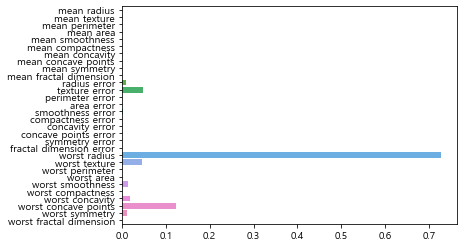

In [43]:
import seaborn as sns

for name, value in zip(cancer.feature_names, tree.feature_importances_):
    print('{0}:{1:.3f}'.format(name,value))
    
sns.barplot(x=tree.feature_importances_, y=cancer.feature_names)

* 결정 트리 그래프에서 최상위 노드가 worst_radius 였던 것을 확인하면 잘 나누고 있었다는 것을 알수 있다.
* 그러나 어떤 특성의 feature_importances_ 값이 낮다고 해서 유용하지 않다는 뜻은 아니다.
* 단지 트리가 그 특성을 선택하지 않았을 뿐 다른 특성이 동일한 정보를 가지고 있어서 일 수도 있다.

### 특성과 클래스와의 관계 파악

#### 특정 특성 1가지 값에 대한 클래스 값인지 그래프 그려서 확인

Feature importances: [0. 1.]


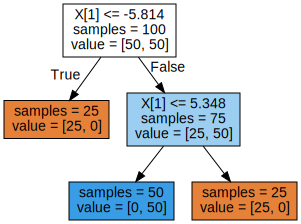

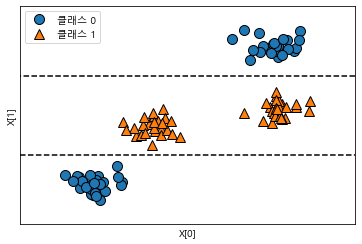

In [48]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

* y축의 특성이 클래스 레이블과 복합적인 관계의 결정 경계
* 위 그래프를 보면 클래스 값과 특성에 따른 관계를 볼 수 있다.
* X[1]특성만으로는 양성인지 음성인지 알 수 없다.

## 회귀나무 DecisionTreeRegressor

    : 의사결정나무의 피처가 연속형 변수 일때 회귀나무 모형을 사용
    
 * 외삽(extrapolation): 훈련 데이터의 범위 밖의 포인트에 대한 예측 불가

#### 컴퓨터 메모리 가격 동향 데이터셋 분석

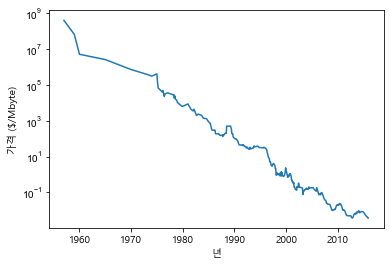

In [53]:
import warnings
warnings.filterwarnings('ignore')
ram_prices = pd.read_csv('../data/ram_price.csv')

plt.yticks(fontname='Arial')
plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel('년')
plt.ylabel('가격 ($/Mbyte)')
plt.show()

#### 두가지 모델로 예측한 2000년 이후 ram 가격 그래프
* 날짜 특성 하나만으로 2000년 이후의 가격을 예측해보자
* 선형 회귀모델과 회귀 결정 트리 모델로 예측한 2000년도 이후의 가격 그래프를 그려서 비교

In [62]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import numpy as np

data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date>=2000]

X_train = data_train.date.to_numpy()[:,np.newaxis]
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor()
linear_reg = LinearRegression()
tree.fit(X_train,y_train)
linear_reg.fit(X_train,y_train)

X_all = ram_prices.date.to_numpy()[:,np.newaxis]

#예측은 전체 기간에 대해서 수행
pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

#### semilogy() : y축에 로그 스케일이 있는 세미 로그 플롯 함수

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


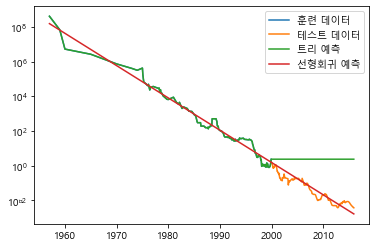

In [63]:
plt.semilogy(data_train.date, data_train.price, label='훈련 데이터')
plt.semilogy(data_test.date, data_test.price, label='테스트 데이터')
plt.semilogy(ram_prices.date, price_tree, label='트리 예측')
plt.semilogy(ram_prices.date, price_lr, label='선형회귀 예측')
plt.legend()

* 트리모델은 훈련데이터를 완벽하게 예측하지만 훈련데이터 밖의 새로운 데이터는 예측불가
* 선형회귀모델은 훈련데이터와 테스트데이터의 미세한 굴곡을 직선으로 근사.

### 결정트리와 매개변수

* 모델 복잡도를 조정하는 사전가지치기 매개변수 *max_depth, max_leaf_node, min_sample_leaf* 중 하나만 지정해도 과대적합을 막는데 충분함

* 장점 
     1. 결정트리는 만들어진 모델을 쉽게 시각화 할 수 있음
     2.데이터의 스케일에 구애받지 않아 특성의 정규화, 표준화 같은 전처리 과정이 필요없음.
     3.특성 스케일이 다르거나 이진특성과 연속적인 특성이 혼합되어도 잘 작동함

* 단점
    1. 사전가지치기를 사용한다고 해도 과대적합이 될수 있음 -> 일반화하기 어려움
    2. 과대적합 문제의 대안으로 앙상블 방법 사용

# 앙상블

   앙상블 학습을 통한 분류는 여러개의 분류기를 생성하고 그 예측을 결합함으로써 
   보다 <br> 정확한 최종 예측을 도출하는 기법

### 앙상블 유형

  일반적으로 Voting, Bagging, Boosting, Stacking 이 있음
  
  * 대표적인 Bagging은 랜덤 포레스트 알고리즘이 있고, 부스팅은 에이다부스팅, 그레디언트 부스팅 회귀 트리 계열의 앙상블이 전반적으로 높은 예측 성능을 나타냄

### 앙상블의 특징

    1. 단일 모델의 약점을 다수의 모델들을 결합하여 보완
    
    2. 뛰어난 성능을 가진 모델들로만 구성하는 것보다 성능이 떨어지더라도 
        서로 다른 유형의 모델을 섞는 것이 오히려 전체 성능에 도움이 됨
        
    3. 랜덤포레스트 및 뛰어난 부스팅 알고리즘들은 모두 결정 트리 알고리즘 기반
    
    4. 결정 트리의 단점인 과적합을 많은 분류기를 결합해 보완하고 장점인
       분류 기준은 강화

### Bagging과 Boosting
    
    1. 보팅과 배깅은 여러개의 분류기가 투표를 통해 최종 예측 결과 결정하는 방식
    2. Bagging : 중복을 허용하여 랜덤하게 훈련 데이터셋을 뽑는 Bagging을 사용해 과대적합 감소하기
    3. Boosting : 앞선 모델의 오차를 학습하는 약한 학습기로 구성된 Boosting으로 강력한 모델 구축하기

## 결정트리 앙상블 기법

* 앙상블은 여러 머신러닝 모델을 연결하여 더 강력한 모델을 만드는 기법
* 다양한 앙상블 기법 중 랜덤 포레스트와 그래디언트 부스팅 결정트리는 둘 다 모델을 구성하는
기본요소로 결정트리를 사용
* 두 모델은 분류와 회귀 문제의 다양한 데이터셋에서 효과적이라고 입증됨

## 1. 랜덤 포레스트
* 훈련 데이터에 과대적합되는 결정트리의 단점을 회피할 수 있는 방법
* 랜덤 포레스트는 기본적으로 여러 결정 트리의 묶음

* 서로 다른 방향으로 과대 적합된 트리를 많이 만들면 그 결과를 평균냄으로써 과대적합된 양을 줄일 수 있음
* 이러한 전략은 구현하기 위해서는 결정 트리를 많이 만들어야 함
* 각각의 트리는 타깃 예측을 잘 해야 하고 다른 트리와는 구별되어야 함


** 랜덤 포레스트에서 트리를 랜덤하게 만드는 방법 두가지 **
1. 데이터를 무작위로 선택하기
2. 분할 테스트에서 특성을 무작위로 선택

### 랜덤포레스트 구축

1. n개의 랜덤한 부트스트랩 샘플을 뽑기(훈련 데이터셋에서 중복을 허용하면서 랜덤하게 n개의 샘플 선택)
2. 각 노드 마다 부트스트랩 샘플에서 결정트리를 학습 
3. 중복을 허용하지 않고 랜덤하게 d개의 특성 선택
4. 정보 이득과 같은 목적함수를 기준으로 최선의 분할을 만드는 특성을 사용해 노드 분할

* 1-2번 단계를 k번 반복
* 각 트리의 예측을 모아 Majority Voting으로 틀래스 레이블 할당 



## 투표 


In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=2)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("트리 {}".format(i))
    mglearn.plots.plot_tree_partition(X, y, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("랜덤 포레스트")
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.show()

* 결정트리처럼 특성 중요도 제공
* 각 트리의 특성 중요도를 취합하여 계산한 것
* 일반적으로 랜덤 포레스트에서 제공하는 특성 중요도가 하나의 트리에서 제공하는 것 보다 더 신뢰도가 높음

#### 랜덤포레스트 Cancer 데이터셋 - 100개의 트리

In [70]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier

cancer = load_breast_cancer()

X_train, X_test , y_train, y_test =train_test_split(cancer.data, cancer.target,random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(forest.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.972


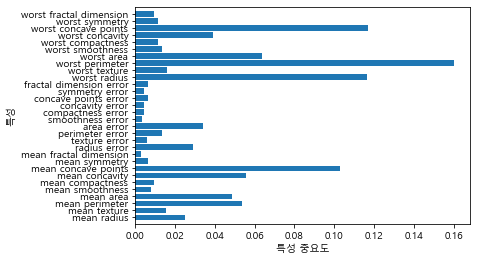

In [71]:
plot_feature_importances_cancer(forest)

#### 장단점과 매개변수

* 하이퍼파라미터 튜닝에 많은 노력을 기울이지 않아도 됨, 가지치기 필요 없음, 데이터 스케일링 필요없음
* n_jobs 매개변수를 이용해 사용할 코어 수 지정가능
* random_state를 다르게 지정하면 전혀 다른 모델이 생성됨
* 랜덤 포레스트는 텍스트 데이터와 같이 매우 차원이 높고 희소한 데이터에는 잘 작동하지 않음 ->선형모델이 더 적합
* 랜덤포레스트가 만들 트리 개수(**n_estimators**)가 중요함 - 트리개수가 많을수록 과대적합을 줄여 분류기의 성능 좋아짐
* 부트스트랩 샘플크기(**max_features**)는 트리가 얼마나 무작위가 될지를 결정하고, 랜덤포레스트의 편향-분산 트레이드오프 조절가능
* 부트스트랩 샘플 크기가 작아지면 개별 트리의 다양성 증가, 과대적합의 영향 감소

## 2. 그레디언트 부스팅 회귀 트리

* 그래디언트 부스팅회귀트리는 여러개의 결정트리를 묶어 강력한 모델을 만드는 앙상블 기법
* 회귀문제, 분류문제에서 모두 사용가능
* 랜덤포레스트와 달리 그래디언트 부스팅은 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 생성
* 강력한 사전 가지치기가 사용됨 
* 그래디언트 부스팅 트리는 머신러닝 경연 대회에서 우승을 많이 차지하였고, 업계에서도 널리 사용된다.
* 랜덤 포레스트보다는 매개변수 설정에 조금 더 민감하지만 잘 조정하면 높은 정확도를 제공 해준다.
* 매개변수 **learning_rate** 로 오차 보완 가능, **max_depth**로 가지치기 가능

#### 유방암 데이터셋을 이용한 그래디언트 부스팅 회귀 트리를 이용한 분류 성능측정

In [74]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train,  y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.965


In [75]:
#max_depth로 사전가지치기 
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

훈련 세트 정확도: 0.991
테스트 세트 정확도: 0.972


In [76]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

훈련 세트 정확도: 0.988
테스트 세트 정확도: 0.965


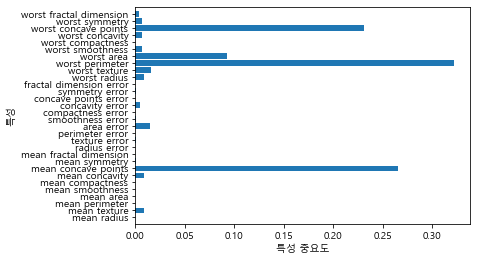

In [77]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

# 커널 서포트 벡터 머신

## 선형 모델과 비선형 특성

### SVM 
  서포트 벡터 머신은 주어진 데이터를 바탕으로 하여<br>
  두 카페고리 사이의 간경을 최대화 하는 데이터 포인트를 찾아내고<br>
  그 서포트벡터에 수직인 경계를 통해 데이터 분류<br>

!['image'](https://miro.medium.com/max/1200/1*06GSco3ItM3gwW2scY6Tmg.png)

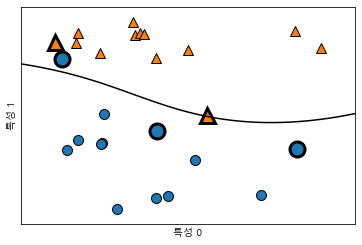

In [79]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()                                                                  
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)                                                
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
# 데이터 포인트 그리기
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# 서포트 벡터
sv = svm.support_vectors_
# dual_coef_ 의 부호에 의해 서포트 벡터의 클래스 레이블이 결정됩니다
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("특성 0")
plt.ylabel("특성 1")
plt.show() # 책에는 없음

#### SVC 매개변수 튜닝

   * **gamma** 매개변수는 가우시안 커널 폭의 역수로 하나의 훈련 샘플이 미치는 영향의 범위 결정
   * gamma값이 작으면 넓은 영역을 의미하고, 크면 영향 범위가 제한적임
   * **C 매개변수**는 선형모델에서 사용한 것 처럼 규제 매개변수, 각 포인트의 중요도를 제한 (dual_coef_값)

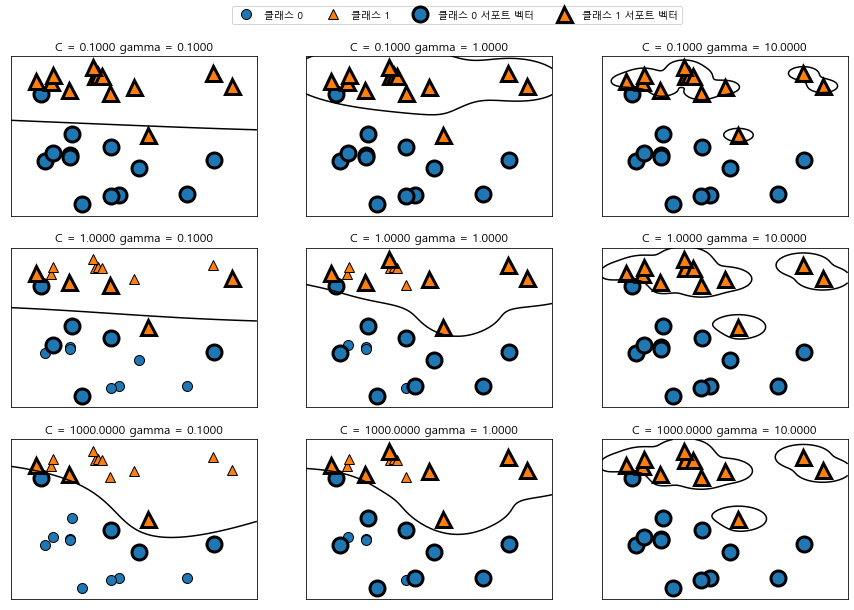

In [80]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["클래스 0", "클래스 1", "클래스 0 서포트 벡터", "클래스 1 서포트 벡터"],
                  ncol=4, loc=(.9, 1.2))
plt.show() # 책에는 없음

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("훈련 세트 정확도: {:.2f}".format(svc.score(X_train, y_train)))
print("테스트 세트 정확도: {:.2f}".format(svc.score(X_test, y_test)))

훈련 세트 정확도: 0.90
테스트 세트 정확도: 0.94


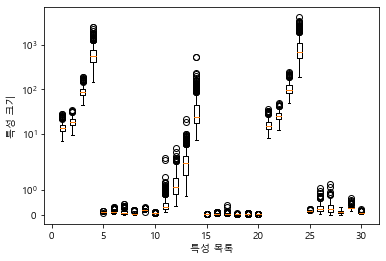

In [82]:
plt.boxplot(X_train, manage_ticks=False)
plt.yscale("symlog")
plt.xlabel("특성 목록")
plt.ylabel("특성 크기")
plt.show()

#### SVM을 위한 전처리
    : 특성값의 범위가 비슷해지도록 조정하는 것 
    
 * 커널 SVM에서는 모든 특성값을 평균이 0이고 단위분산이 되도록하거나 0,1사이로 맞추는 경우가 많음
 * StandardScaler와 MinMaxSclaer 전처리 메서드 주로 사용

In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_tn_std = scaler.transform(X_train)
X_te_std = scaler.transform(X_test)

svc.fit(X_tn_std, y_train)
print("훈련 세트 정확도: {:.2f}".format(svc.score(X_tn_std, y_train)))
print("테스트 세트 정확도: {:.2f}".format(svc.score(X_te_std, y_test)))

훈련 세트 정확도: 0.99
테스트 세트 정확도: 0.97


In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
scaler.fit(X_train)
X_tn_m = scaler.transform(X_train)
X_te_m = scaler.transform(X_test)

svc.fit(X_tn_std, y_train)
print("훈련 세트 정확도: {:.2f}".format(svc.score(X_tn_m, y_train)))
print("테스트 세트 정확도: {:.2f}".format(svc.score(X_te_m, y_test)))

훈련 세트 정확도: 0.37
테스트 세트 정확도: 0.37


In [92]:
cancer_data = X_tn_std
cancer_df = pd.DataFrame(data=X_tn_std, columns=cancer.feature_names)
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-0.650799,-0.430573,-0.680248,-0.626983,-0.913819,-0.933352,-0.787631,-0.679444,0.254041,-0.798772,...,-0.666144,0.018492,-0.681179,-0.631501,0.191962,-0.507751,-0.695929,-0.364339,0.323499,-0.757849
1,-0.828353,0.152265,-0.827738,-0.753094,0.652812,-0.708753,-1.066546,-1.071909,0.489037,-0.341454,...,-0.887045,0.023445,-0.900486,-0.771001,0.432101,-1.029169,-1.292774,-1.450367,0.625631,-1.030714
2,1.682772,2.189772,1.600098,1.673839,0.103624,-0.005326,0.705766,1.257731,-0.190645,-1.064688,...,1.508098,2.082033,1.401345,1.439992,-0.694368,-0.399657,0.262556,0.725046,-0.513298,-0.966014
3,-0.160411,-0.338290,-0.241878,-0.239207,-1.220208,-1.247434,-0.875740,-0.948189,-0.837790,-1.083682,...,-0.167070,0.076272,-0.252000,-0.253640,-1.200842,-1.164088,-0.825141,-0.967772,-0.888195,-1.176430
4,0.713269,0.234834,0.612740,0.553289,-1.546108,-0.642973,-0.665094,-0.672481,0.149196,-1.368593,...,0.585631,0.152210,0.584842,0.335264,-1.379854,0.258130,-0.109936,-0.425826,2.816487,-0.411282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,1.310754,0.181407,1.178115,1.232174,-0.515658,-0.885548,-0.107748,0.239495,-0.920942,-1.849288,...,0.745170,-0.220878,0.634952,0.594798,-0.358173,-0.901896,-0.244699,0.215446,-0.521207,-1.472362
422,-0.478881,1.167376,-0.334878,-0.506984,1.606665,2.685120,1.767924,0.935857,0.814417,2.894839,...,-0.250931,2.483186,-0.289140,-0.300937,2.305182,5.306877,4.217126,1.613032,2.324533,6.974084
423,-1.331142,-0.221723,-1.324284,-1.055037,0.327635,-0.871325,-0.784826,-0.904859,-1.080017,1.018812,...,-0.878864,-0.102018,-0.933499,-0.765025,0.034781,-0.975056,-0.782743,-0.988065,-0.699955,-0.122663
424,-1.251102,-0.246008,-1.287002,-1.028648,-1.941379,-1.584827,-1.130378,-1.267483,-0.548563,0.270739,...,-1.298576,-0.793717,-1.332613,-0.996898,-2.677913,-1.486588,-1.360156,-1.758873,-1.562061,-1.009897
